In [ ]:
import os
import pandas as pd
import numpy as np
import pywt
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Input, LSTM, Dense, Attention, Concatenate, TimeDistributed, Dropout, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Carrega o dataset
data = pd.read_csv("dataset.csv")

# Converte a coluna 'id' para string e extrai a parte antes do ponto
data['id_str'] = data['id'].astype(str).apply(lambda x: x.split('.')[0]) 
data['id_datetime'] = pd.to_datetime(data['id_str'], errors='coerce') 

# Define 'id_datetime' como índice do dataframe
data.set_index('id_datetime', inplace=True)
data.drop(columns=['id_str'], inplace=True)

# Cria um novo dataframe 'variables' com o mesmo índice de 'data'
variables = pd.DataFrame(index=data.index)

def wavelet_denoising(signal, wavelet='bior2.2', level=4):
    """
    Realiza a denoising de um sinal utilizando transformada wavelet.
    
    :param signal: Sinal a ser denoizado.
    :param wavelet: Tipo de wavelet a ser utilizada.
    :param level: Nível de decomposição.
    :return: Sinal denoizado.
    """
    # Decompõe o sinal utilizando a wavelet especificada
    coeffs = pywt.wavedec(signal, wavelet, mode='symmetric', level=level)
    
    # Estima o ruído
    sigma = np.median(np.abs(coeffs[-level])) / 0.6745
    uthresh = sigma * np.sqrt(2 * np.log(len(signal)))
    
    # Aplica thresholding suave nos coeficientes de detalhe
    coeffs[1:] = [pywt.threshold(i, value=uthresh, mode='soft') for i in coeffs[1:]]
    
    # Reconstrói o sinal a partir dos coeficientes denoizados
    reconstructed_signal = pywt.waverec(coeffs, wavelet, mode='symmetric')
    
    # Retorna o sinal denoizado com o mesmo comprimento do original
    return reconstructed_signal[:len(signal)]

# Lista das colunas que serão denoizadas
columns_to_denoise = ['ws100', 'humid', 'wdisp100', 'temp', 'vertdisp100']

# Aplica a denoising wavelet em cada coluna especificada
for col in columns_to_denoise:
    if col in data.columns:
        denoised_signal = wavelet_denoising(data[col].values)
        variables[f'{col}_wavelet'] = denoised_signal  
    else:
        raise ValueError(f"A coluna '{col}' não existe no dataset.")

# Inicializa escaladores MinMax para normalizar os dados
scaler_ws100 = MinMaxScaler()
scaler_other = MinMaxScaler()

# Cria uma cópia dos dados denoizados para escalonamento
variables_scaled = variables.copy()

# Aplica o escalonamento na coluna 'ws100_wavelet'
variables_scaled[['ws100_wavelet']] = scaler_ws100.fit_transform(variables[['ws100_wavelet']])

# Aplica o escalonamento nas demais colunas denoizadas
variables_scaled[['humid_wavelet', 'wdisp100_wavelet', 'temp_wavelet', 'vertdisp100_wavelet']] = scaler_other.fit_transform(
    variables[['humid_wavelet', 'wdisp100_wavelet', 'temp_wavelet', 'vertdisp100_wavelet']]
)

print(f"Forma dos dados escalados: {variables_scaled.shape}")

# Define o número de passos de entrada e saída para as sequências
input_steps = 144 # 24 horas
output_steps = 6 # uma hora

def create_sequences(data, input_steps, output_steps, target_col_index):
    """
    Cria sequências de entrada e saída para o modelo Seq2Seq usando Teacher forcing.
    
    :param data: Dados escalonados.
    :param input_steps: Número de passos de entrada.
    :param output_steps: Número de passos de saída.
    :param target_col_index: Índice da coluna alvo.
    :return: Arrays de sequências para encoder, decoder e os alvos.
    """
    X_encoder = []
    X_decoder = []
    y_decoder = []
    
    # Itera sobre os dados para criar as sequências
    for i in range(len(data) - input_steps - output_steps + 1):
        
        # Sequência de entrada para o encoder
        X_encoder.append(data[i:(i + input_steps)])
        
        # Inicializa a entrada do decoder com zeros
        decoder_input = np.zeros((output_steps, 1))
        
        # Define o primeiro passo do decoder como o último valor do encoder
        decoder_input[0] = data[i + input_steps - 1, target_col_index]
        
        # Define os passos subsequentes do decoder com os valores reais
        decoder_input[1:] = data[i + input_steps:i + input_steps + output_steps - 1, target_col_index].reshape(-1, 1)
        
        X_decoder.append(decoder_input)
        
        # Define os alvos do decoder
        y_decoder.append(data[i + input_steps:i + input_steps + output_steps, target_col_index].reshape(-1, 1))
    
    return np.array(X_encoder), np.array(X_decoder), np.array(y_decoder)

# Converte os dados escalonados para um array NumPy
data_array = variables_scaled.values

# Obtém o índice da coluna alvo ('ws100_wavelet')
target_col_index = variables_scaled.columns.get_loc('ws100_wavelet')

# Cria as sequências para o modelo
X_encoder, X_decoder, y_decoder = create_sequences(data_array, input_steps, output_steps, target_col_index)

# Exibe as formas das sequências criadas
print(f"Forma de X_encoder: {X_encoder.shape}")
print(f"Forma de X_decoder: {X_decoder.shape}")
print(f"Forma de y_decoder: {y_decoder.shape}")

# Define os índices para divisão dos dados em treino, validação e teste
train_end = int(X_encoder.shape[0] * 0.75)
val_end = int(X_encoder.shape[0] * 0.95)

# Divide os dados para treino
X_encoder_train = X_encoder[:train_end]
X_decoder_train = X_decoder[:train_end]
y_decoder_train = y_decoder[:train_end]

# Divide os dados para validação
X_encoder_val = X_encoder[train_end:val_end]
X_decoder_val = X_decoder[train_end:val_end]
y_decoder_val = y_decoder[train_end:val_end]

# Divide os dados para teste
X_encoder_test = X_encoder[val_end:]
X_decoder_test = X_decoder[val_end:]
y_decoder_test = y_decoder[val_end:]

# Exibe as formas das divisões
print(f"Treino X_encoder: {X_encoder_train.shape}, Treino X_decoder: {X_decoder_train.shape}, Treino y_decoder: {y_decoder_train.shape}")
print(f"Validação X_encoder: {X_encoder_val.shape}, Validação X_decoder: {X_decoder_val.shape}, Validação y_decoder: {y_decoder_val.shape}")
print(f"Teste X_encoder: {X_encoder_test.shape}, Teste X_decoder: {X_decoder_test.shape}, Teste y_decoder: {y_decoder_test.shape}")

# Define o número de features para encoder e decoder
num_encoder_features = X_encoder_train.shape[2]
num_decoder_features = 1  # Apenas a coluna alvo

def build_seq2seq_attention_model(input_steps, output_steps, num_encoder_features, num_decoder_features):
    """
    Constrói um modelo Seq2Seq com mecanismo de atenção.
    
    :param input_steps: Número de passos de entrada.
    :param output_steps: Número de passos de saída.
    :param num_encoder_features: Número de features no encoder.
    :param num_decoder_features: Número de features no decoder.
    :return: Modelo compilado.
    """
    # Define o otimizador
    optimizer = Adam(learning_rate=1e-4)
    
    # Define as entradas do encoder
    encoder_inputs = Input(shape=(input_steps, num_encoder_features), name='encoder_inputs')
    
    # Camada LSTM do encoder
    encoder_lstm = LSTM(64, return_sequences=True, return_state=True, name='encoder_lstm')
    encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
    
    # Aplica Dropout para regularização
    encoder_outputs = Dropout(0.2)(encoder_outputs)
    
    # Define as entradas do decoder
    decoder_inputs = Input(shape=(output_steps, num_decoder_features), name='decoder_inputs')
    
    # Camada LSTM do decoder, recebendo os estados do encoder
    decoder_lstm = LSTM(64, return_sequences=True, return_state=True, name='decoder_lstm')
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=[state_h, state_c])
    
    # Aplica Dropout no decoder
    decoder_outputs = Dropout(0.2)(decoder_outputs)
    
    # Mecanismo de atenção
    attention_layer = Attention(name='attention_layer')
    attention_outputs = attention_layer([decoder_outputs, encoder_outputs])
    
    # Combina as saídas do decoder com a atenção
    decoder_combined_context = Concatenate(axis=-1)([decoder_outputs, attention_outputs])
    
    # Camada final para gerar as previsões
    decoder_dense = TimeDistributed(Dense(1, activation='linear'), name='output_layer')
    decoder_outputs_final = decoder_dense(decoder_combined_context)
    
    # Define o modelo com entradas do encoder e decoder e saída final
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs_final)
    
    # Compila o modelo com a função de perda MSE e métrica MAE
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    return model

# Constrói o modelo Seq2Seq com atenção
model = build_seq2seq_attention_model(input_steps, output_steps, num_encoder_features, num_decoder_features)

# Exibe o resumo do modelo
model.summary()

# Define os callbacks para treinamento
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
    ModelCheckpoint('best_model.h5.keras', monitor='val_loss', save_best_only=True)
]

# Treina o modelo com os dados de treino e validação
history = model.fit(
    [X_encoder_train, X_decoder_train], y_decoder_train, 
    epochs=200,  
    batch_size=32, 
    validation_data=([X_encoder_val, X_decoder_val], y_decoder_val),
    callbacks=callbacks,
    verbose=1
)

# Carrega o melhor modelo salvo
model = tf.keras.models.load_model('best_model.h5.keras', custom_objects={'Attention': Attention})
print("Melhor modelo carregado com sucesso.")

Forma dos dados escalados: (7561, 5)
Forma de X_encoder: (7412, 144, 5)
Forma de X_decoder: (7412, 6, 1)
Forma de y_decoder: (7412, 6, 1)
Treino X_encoder: (5559, 144, 5), Treino X_decoder: (5559, 6, 1), Treino y_decoder: (5559, 6, 1)
Validação X_encoder: (1482, 144, 5), Validação X_decoder: (1482, 6, 1), Validação y_decoder: (1482, 6, 1)
Teste X_encoder: (371, 144, 5), Teste X_decoder: (371, 6, 1), Teste y_decoder: (371, 6, 1)


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 144, 5)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, 6, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 144, 64), │     17,920 │ encoder_inputs[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, 6, 64),   │     16,896 │ decoder_inputs[0… │
│                     │ (None, 64),       │            │ encoder_lstm[0][… │
│                     │ (None, 64)]       │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 6, 64)     │          0 │ decoder_lstm[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 144, 64)   │          0 │ encoder_lstm[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ (None, 6, 64)     │          0 │ dropout_19[0][0], │
│ (Attention)         │                   │            │ dropout_18[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 6, 128)    │          0 │ dropout_19[0][0], │
│ (Concatenate)       │                   │            │ attention_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 6, 1)      │        129 │ concatenate_9[0]… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 34,945 (136.50 KB)

 Trainable params: 34,945 (136.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 30s 161ms/step - loss: 0.1499 - mae: 0.3101 - val_loss: 0.0077 - val_mae: 0.0708 - learning_rate: 1.0000e-04
Epoch 2/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 26s 152ms/step - loss: 0.0079 - mae: 0.0696 - val_loss: 0.0054 - val_mae: 0.0584 - learning_rate: 1.0000e-04
Epoch 3/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 26s 150ms/step - loss: 0.0064 - mae: 0.0617 - val_loss: 0.0037 - val_mae: 0.0470 - learning_rate: 1.0000e-04
Epoch 4/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 26s 149ms/step - loss: 0.0052 - mae: 0.0550 - val_loss: 0.0027 - val_mae: 0.0393 - learning_rate: 1.0000e-04
Epoch 5/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 28s 163ms/step - loss: 0.0043 - mae: 0.0497 - val_loss: 0.0022 - val_mae: 0.0353 - learning_rate: 1.0000e-04
Epoch 6/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 26s 151ms/step - loss: 0.0036 - mae: 0.0452 - val_loss: 0.0019 - val_mae: 0.0331 - learning_rate: 1.0000e-04
Epoch 7/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 31s 177ms/step - loss: 0.0032 - mae: 0.0426 - val_loss: 0.0

KeyboardInterrupt: 

In [ ]:
def rolling_forecasting_real_time_improved(model, data_scaled, input_steps, output_steps, scaler_ws100):
    """
    Realiza rolling forecasting simulando um cenário de previsão em tempo real com feedback do decoder.
    
    :param model: Modelo treinado.
    :param data_scaled: Dados escalonados (inclui treino, validação e teste).
    :param input_steps: Número de passos de entrada.
    :param output_steps: Número de passos de saída.
    :param scaler_ws100: Escalador para a coluna 'ws100_wavelet'.
    :return: Arrays com previsões e valores reais.
    """
    predictions = []
    actuals = []
    
    # Definimos a posição inicial para o conjunto de teste
    test_start = int(data_scaled.shape[0] * 0.95)  # Mesmo que val_end no código original
    test_data = data_scaled[test_start:]
    
    # Inicializa a janela de entrada com os últimos 'input_steps' dados antes do teste
    window_start = test_start - input_steps
    window_end = test_start
    window = data_scaled[window_start:window_end].copy()
    
    for i in range(len(test_data) - output_steps + 1):
        # Preparar encoder input
        encoder_input = window.reshape(1, input_steps, data_scaled.shape[1])
        
        # Inicializa a entrada do decoder com zeros
        decoder_input = np.zeros((1, output_steps, 1))
        
        # Primeiro passo do decoder é o último valor do encoder
        decoder_input[0, 0, 0] = encoder_input[0, -1, target_col_index]
        
        # Previsões para os passos subsequentes
        for t in range(1, output_steps):
            # Previsão anterior
            previous_pred = decoder_input[0, t-1, 0]
            decoder_input[0, t, 0] = previous_pred
        
        # Realiza a previsão
        pred = model.predict([encoder_input, decoder_input])
        
        # Extrai a última previsão
        last_pred = pred[0, -1, 0]
        predictions.append(last_pred)
        
        # Obtém o valor real correspondente
        last_actual = test_data[i + output_steps - 1, target_col_index]
        actuals.append(last_actual)
        
        # Atualiza a janela de entrada com o próximo passo de teste real
        window = np.vstack([window, test_data[i + output_steps - 1]])
        window = window[1:]  # Mantém o tamanho da janela
        
    # Converte as previsões e valores reais para arrays NumPy
    predictions = np.array(predictions).reshape(-1, 1)
    actuals = np.array(actuals).reshape(-1, 1)
    
    # Inverte o escalonamento para obter os valores originais
    predictions_inverse = scaler_ws100.inverse_transform(predictions)
    actuals_inverse = scaler_ws100.inverse_transform(actuals)
    
    return predictions_inverse, actuals_inverse

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

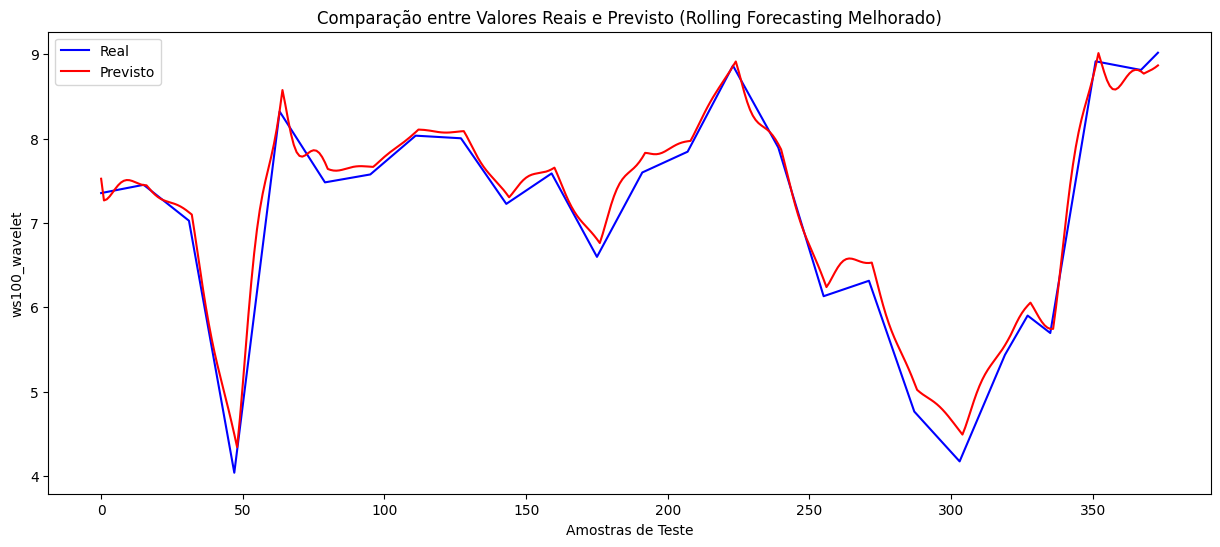

Mean Absolute Error (MAE): 0.1552
Mean Squared Error (MSE): 0.0400
Root Mean Squared Error (RMSE): 0.2000


In [ ]:
# Realiza rolling forecasting simulando previsão em tempo real com feedback do decoder
predictions, actuals = rolling_forecasting_real_time_improved(
    model, 
    data_scaled=variables_scaled.values, 
    input_steps=input_steps, 
    output_steps=output_steps, 
    scaler_ws100=scaler_ws100
)

# Plotando as previsões versus os valores reais
plt.figure(figsize=(15, 6))
plt.plot(actuals, label='Real', color='blue')
plt.plot(predictions, label='Previsto', color='red')
plt.title('Comparação entre Valores Reais e Previsto (Rolling Forecasting Melhorado)')
plt.xlabel('Amostras de Teste')
plt.ylabel('ws100_wavelet')
plt.legend()
plt.show()

# Calculando e exibindo métricas de desempenho
mae = mean_absolute_error(actuals, predictions)
mse = mean_squared_error(actuals, predictions)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")